## Thymus quinquecostatus quick inspection

This genome was obtained with PacBio RS and a genome coverage of 40.0x.

## Assembly statistics

- Contig N50 -> 8,059,748
- Contig L50 -> 23

> Contig N50 is the shortest contig length that needs to be included for covering 50% of the genome

> Contig L50. Given a set of contigs, each with its own length, the L50 is defined as count of smallest number of contigs whose length sum makes up half of genome size

The assembly has 13 pseudo-chromosomes, which correspond to Linkage groups LG01-LG13. There are 465 unplaced scaffolds. 

In [1]:
unplaced_length <- 39913656
assembly_length <- 528675121
(unplaced_length/assembly_length)*100

[1] 7.549751

Unplaced sequences are 7.5% of the total genome assembly, so it seems reasonable to me to use the 13 pseudo-chromosomes for assembly. 

## Mapped reads

We are mapping a super high percentage of the reads (over 99%). 

The high number of secondary alignments could imply that some of the reads are matching highly repetitive regions. 

We have a pretty high number of supplementary alignments. I think this doesn't mean anything "important". Large insertions or deletions can cause supplementary alignments to be created (supplementary often -> split alignments). Minimap2 tries with large indels up to 100kb. This is something we will expect when mapping 2 different genomes. 

https://arxiv.org/abs/2108.03515

According to samtools stats, we are having an error rate of 15% which is very high (compared with the expected sequence identity for, at least, coding regions). If we check how we did the alignment, we can see that there are some flags for sequence divergence. The error rate seems like a nice rough estimator to me. 

> Minimap2 has three presets for full-genome alignment: "asm5" for sequence divergence below 1%, "asm10" for divergence around a couple of percent and "asm20" for divergence not more than 10%. In theory, with the right setting, minimap2 should work for sequence pairs with sequence divergence up to ~15%, but this has not been carefully evaluated.

https://github.com/lh3/minimap2/blob/master/cookbook.md#cross-species-full-genome-alignment

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.0
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: cowplot


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Loading required package: rwantshue

Warning message in Sys.setlocale(locale = "English_Denmark"):
“OS reports request to set locale to "English_Denmark" cannot be honored”

── Column specification ────────────────────────────────────────────────────────
cols(
  length = col_double(),
  n = col_double()
)



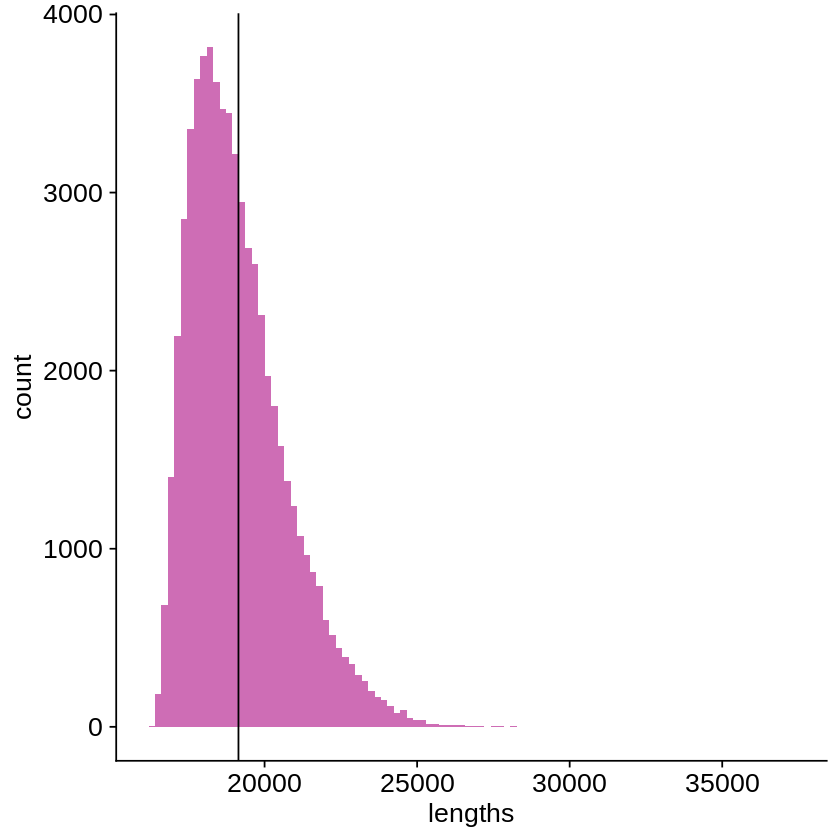

In [2]:
library(tidyverse)
source("format.R")
reads <- read_table("../results/filtered/sequence_length_dist.txt",col_names = c("length", "n")) |>
    arrange(-length)
data.frame(
    lengths = rep(reads$length, reads$n)
) |>
    ggplot(aes(x = lengths, fill = "lavanda"))+
    geom_histogram(bins = 100) +
    geom_vline(xintercept = 19144)+
    guides(fill = "none")

## Modeling mapped reads

For reducing the computational cost, I have computed the number of mapped reads per window for k = 1000 and k = 25000. I would expect those reads to be randomly distributed across the genome. I have obtained this data using pysamstats. 

https://github.com/alimanfoo/pysamstats


In [3]:
accession_list_chr = c(
    "CM044164.1", "CM044165.1", "CM044166.1", "CM044167.1",
    "CM044168.1", "CM044169.1", "CM044170.1", "CM044171.1",
    "CM044172.1", "CM044173.1", "CM044174.1", "CM044175.1",
    "CM044176.1"
)
chr_hues <- get_wants_hue(13)

data <- read_tsv("../results/aligned_stats/binned_coverage_big.txt", show_col_types = FALSE) |>
    filter(chrom %in% accession_list_chr)
head(data)

chrom,pos,gc,reads_all,reads_pp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
CM044164.1,12501,39,6,0
CM044164.1,37501,39,3,0
CM044164.1,62501,38,10,0
CM044164.1,87501,41,0,0
CM044164.1,112501,41,2,0
CM044164.1,137501,40,11,0


### Number of windows per pseudochromosome

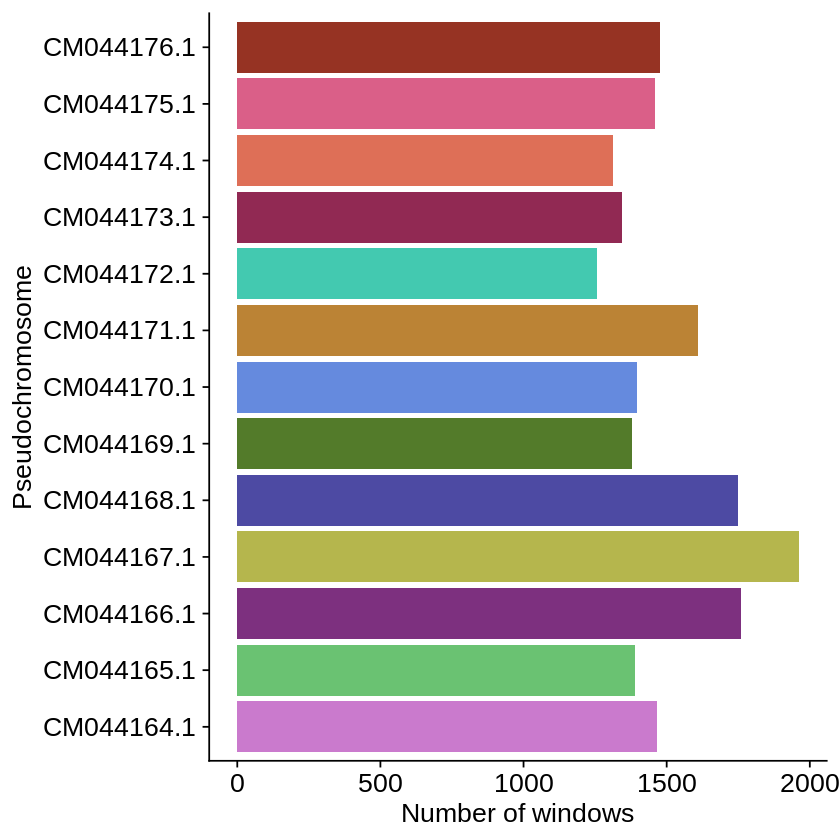

In [4]:
data |>
  group_by(chrom)|>
  summarise(n = n()) |>
  ggplot(aes(y = chrom, x =n, fill = chrom))+
  geom_col() +
  scale_fill_manual(values = chr_hues)+
  guides(fill = "none")+
  xlab("Number of windows")+
  ylab("Pseudochromosome")

### Variance-mean ratio

According to the variance-mean ratio, counts are highly clumped. 

In [5]:
data |>
  group_by(chrom)|>
  summarise(
      mean = mean(reads_all),
      variance = var(reads_all),
      ratio = variance/mean
  ) |> t()

chrom,CM044164.1,CM044165.1,CM044166.1,CM044167.1,CM044168.1,CM044169.1,CM044170.1,CM044171.1,CM044172.1,CM044173.1,CM044174.1,CM044175.1,CM044176.1
mean,13.6,12.9,14.0,14.8,13.4,15.3,12.5,12.2,12.3,14.2,12.9,15.0,12.5
variance,421,406,636,1237,431,3015,342,292,253,431,240,865,304
ratio,30.9,31.3,45.5,83.4,32.2,196.6,27.4,23.9,20.6,30.4,18.6,57.7,24.3


### Distribution of the number of mapped reads per window


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




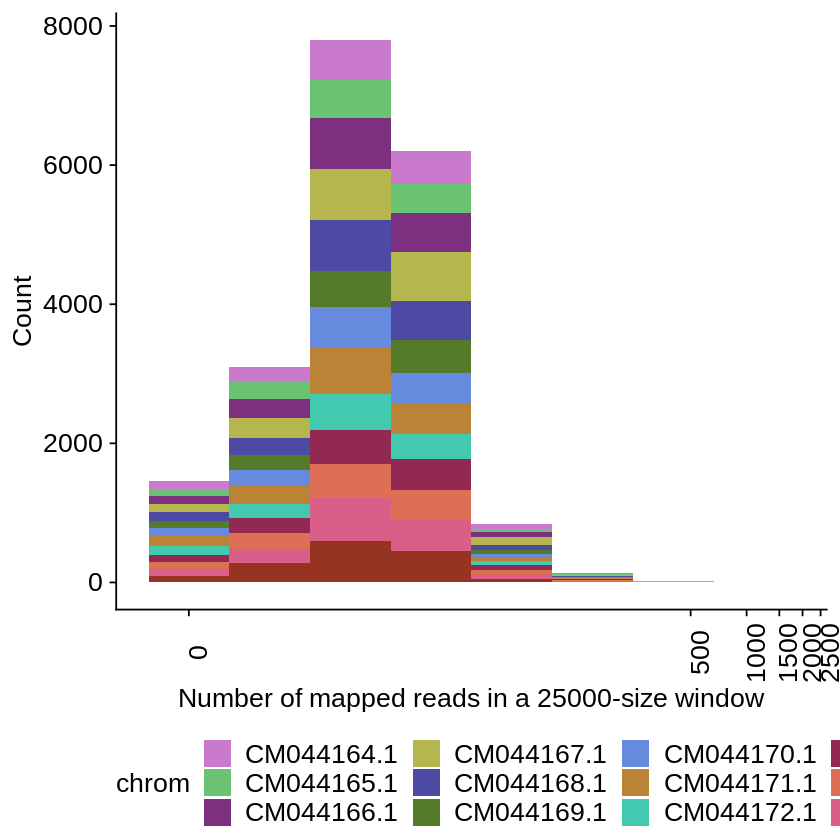

In [6]:
library(scales)
data |>
  ggplot(aes(x = reads_all, fill = chrom))+
  geom_histogram(binwidth = 1) +
  scale_fill_manual(values = chr_hues)+
  xlab("Number of mapped reads in a 25000-size window")+
  ylab("Count")+
  scale_x_continuous(
    trans = pseudo_log_trans()
    )+ 
  theme(
      axis.text.x = element_text(angle = 90),
      legend.position="bottom", legend.box = "horizontal"
  )

### Formulating bayesian modeling

For this model, I would assume that a) non conserved regions are evolving fast enough that there are no chances of mapping in those, b) those non-conserved regions are randomly distributed and c) the event of mapping a read in a window happens throughout a Poisson process. 

That is, the probability of a window being non conserved has a probability $p$ and follows a Bernouilli distribution, and mapping a count into a window has a success rate of $\lambda$.

Then, the probability of a window without any count is given by

$$
Pr(0|p, \lambda) = Pr(\text{non conserved}|p) + Pr(\text{conserved}|p)\times Pr(0|\lambda) \\
= p + (1-p) e^{-\lambda}
$$

### Simulating data from generative model

In [7]:
generative_model <- function(n_windows, p, lambda){
    conserved <- rbinom(n_windows, 1, 1-p)
    conserved * rpois(n_windows, lambda)
}
generative_model(100, 0.5, 10)

[1]  0  0  0 14  0 10  8  0  0  9 11  0  0  6  0  0  7  0  0 13  0  0  0  0  6
 [26]  2 13 14  0  0  9  0 10  3  7  0  0 10  6  0  7  6  6  8  0  0  0 15  8  8
 [51]  0  0  0  0 16  0  0  0 14  7 12  0 13  0  0  0  7 16 11  0  8 11  0  0 10
 [76]  9  7  5 11  0  9 14  8  0  0  0 17  0  0  0 14  0 10  0 11  0  0 10  0  7

The bayesian model we are going to use is formulated as follows:

$$
\begin{align*}
y_i & \sim \text{ZIPoisson} (p_i, \lambda_i)\\
\text{logit} (p_i)     & = \alpha_p + \beta_p x_i \\
\text{log} (\lambda_i) & = \alpha_\lambda + \beta_\lambda x_i
\end{align*}
$$

### Fitting model in simulated data
Now, we are going to simulate data for the first chromosome. We would simulate it with the following parameters:


In [8]:
chr_bp <- 36629419
(n_windows <- ceiling(chr_bp/25000) - 1)
(p <- mean(data |> filter(chrom == "CM044164.1") |> pull(reads_all) == 0))
(lambda <- mean(data |> filter(chrom == "CM044164.1" & reads_all != 0) |> pull(reads_all)))

[1] 1465

[1] 0.0375

[1] 14.2

In [9]:
# First chromosome size
set.seed(1)
simulated_counts <- tibble(Y = generative_model(n_windows, p, lambda))
library(brms)
model <- brm(
    data = simulated_counts, family = zero_inflated_poisson,
      Y ~ 1,
      prior = c(prior(normal(0, 10), class = Intercept),
                prior(beta(1, 1), class = zi)),  # the brms default is beta(1, 1)
      cores = 8,
      seed = 11) 
model

Loading required package: Rcpp

Loading 'brms' package (version 2.19.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


Compiling Stan program...

Start sampling



 Family: zero_inflated_poisson 
  Links: mu = log; zi = identity 
Formula: Y ~ 1 
   Data: simulated_counts (Number of observations: 1465) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     2.65      0.01     2.63     2.66 1.00     3823     2711

Family Specific Parameters: 
   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
zi     0.03      0.00     0.02     0.04 1.00     2975     2316

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

It's a bit confusing, but zi it's already in the probabilistic metric and you don't have to modify it:


https://cran.r-project.org/web/packages/brms/vignettes/brms_families.html#zero-inflated-and-hurdle-models
https://bookdown.org/ajkurz/Statistical_Rethinking_recoded/monsters-and-mixtures.html

As we can see, our model worked quite nicely with the simulated data. We are getting an estimated $p$ of 0.03 (true value 0.04) and $\lambda$ of 14.15 (true value 14.16). 

In [10]:
exp(2.65)

[1] 14.2

In [11]:
library(tidybayes)
library(posterior)
set.seed(1)
counts <- model |>
    spread_draws(b_Intercept, zi) |>
    rowwise()|>
    mutate(count = rbinom(1, 1, 1-zi) * rpois(1, exp(b_Intercept))) |>
    pull(count) |>
    sample(size = n_windows,replace = TRUE)


Attaching package: ‘tidybayes’


The following objects are masked from ‘package:brms’:

    dstudent_t, pstudent_t, qstudent_t, rstudent_t


This is posterior version 1.4.1


Attaching package: ‘posterior’


The following objects are masked from ‘package:stats’:

    mad, sd, var


The following objects are masked from ‘package:base’:

    %in%, match




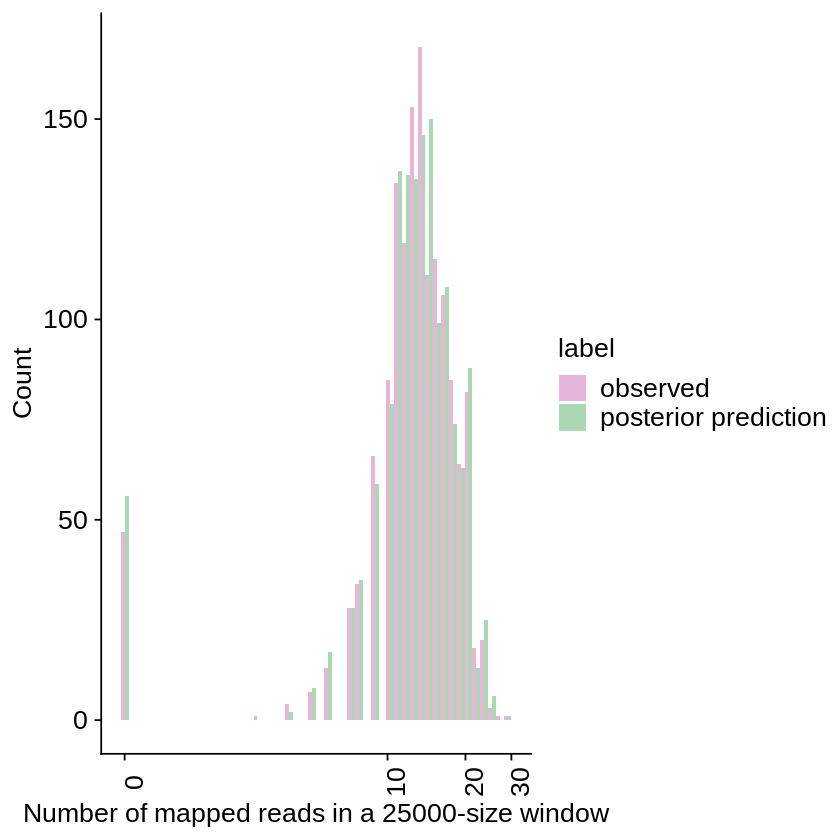

In [12]:
tibble(
    Y = c(simulated_counts$Y, counts),
    label = c(rep("observed", n_windows), rep("posterior prediction", n_windows))
) |>
    ggplot(aes(x = Y, fill = label))+
    geom_histogram(alpha = 0.5, position = "dodge", bins= 50)+
  xlab("Number of mapped reads in a 25000-size window")+
  ylab("Count")+
  scale_x_continuous(
    trans = pseudo_log_trans()
    )+ 
  theme(axis.text.x = element_text(angle = 90))

### Modelling real data

In [13]:
set.seed(1)
model <- brm(
    data = data, family = zero_inflated_poisson,
    reads_all ~ 1,
    prior = c(
        prior(normal(0, 10), class = Intercept),
        prior(beta(1, 1), class = zi)),
    cores = 8,file = "big_window_brm.rds", seed = 11) 
model

 Family: zero_inflated_poisson 
  Links: mu = log; zi = identity 
Formula: reads_all ~ 1 
   Data: data (Number of observations: 19557) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     2.64      0.00     2.64     2.65 1.00     4050     2660

Family Specific Parameters: 
   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
zi     0.03      0.00     0.03     0.04 1.00     1503     1854

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

First, we are going to take a look to how the posterior distribution looks:

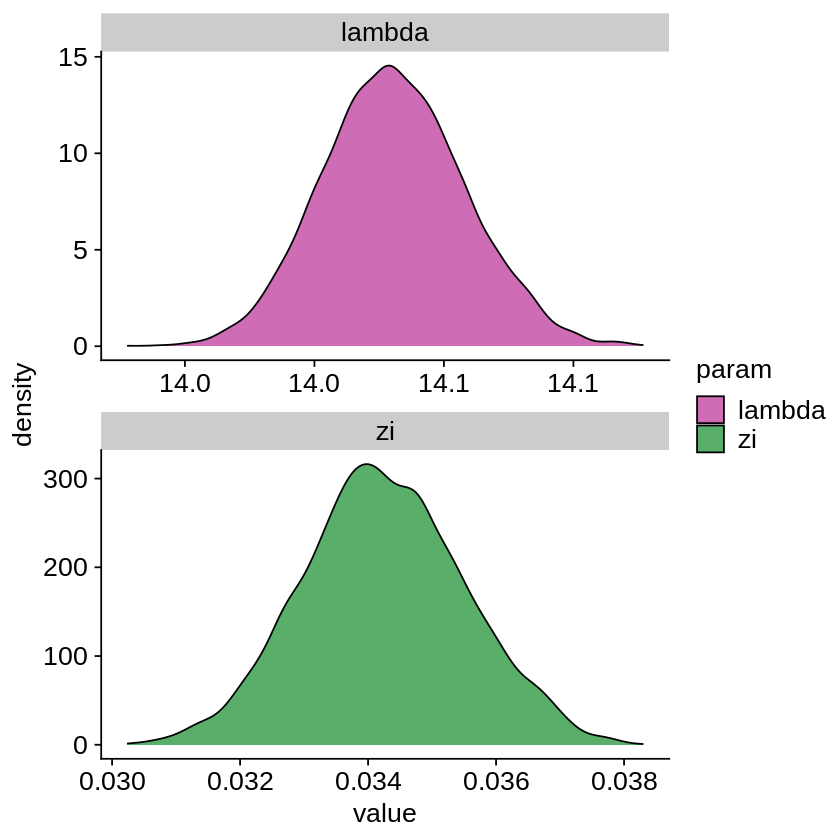

In [14]:
model |>
    spread_draws(b_Intercept, zi) |>
    mutate(lambda = exp(b_Intercept)) |>
    select(zi, lambda) |>
    pivot_longer(cols= everything(),names_to = "param") |>
    ggplot(aes(x = value, fill = param))+
    geom_density()+
    facet_wrap(~param,scales = "free",nrow = 2)

And, now, we are going how generated data with our generative model and parameters sampled from the posterior looks like: 

In [15]:
set.seed(1)
counts <- model |>
    spread_draws(b_Intercept, zi) |>
    rowwise()|>
    mutate(count = rbinom(1, 1, 1-zi) * rpois(1, exp(b_Intercept))) |>
    pull(count) |>
    sample(size = nrow(data),replace = TRUE)

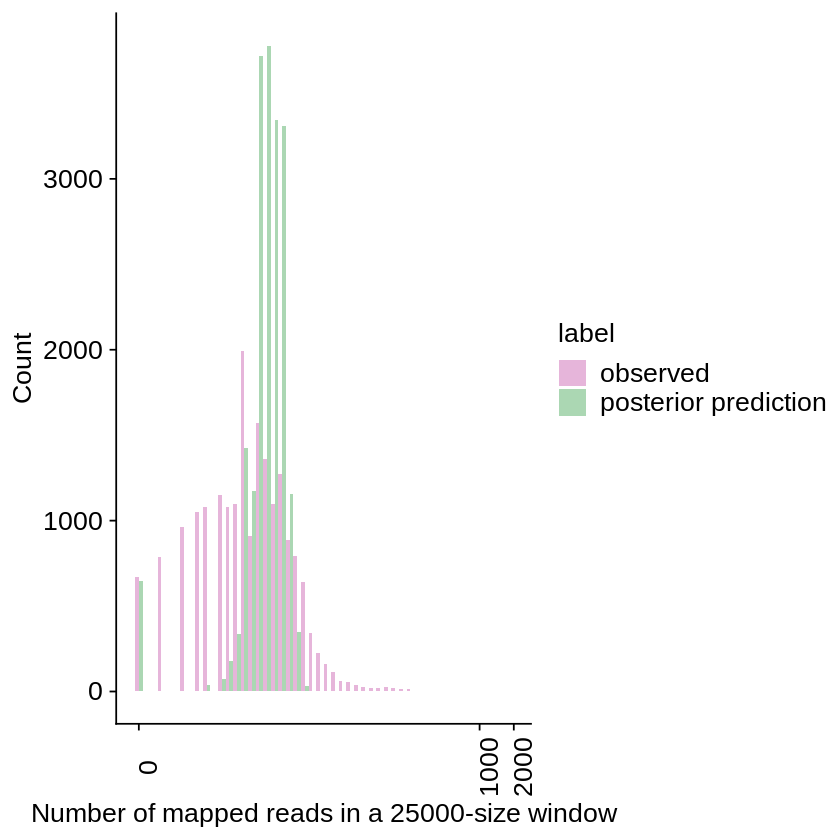

In [16]:
tibble(
    Y = c(data$reads_all, counts),
    label = c(rep("observed", nrow(data)), rep("posterior prediction", nrow(data)))
) |>
    ggplot(aes(x = Y, fill = label))+
    geom_histogram(alpha = 0.5, position = "dodge", bins= 50)+
  xlab("Number of mapped reads in a 25000-size window")+
  ylab("Count")+
  scale_x_continuous(
    trans = pseudo_log_trans()
    )+ 
  theme(axis.text.x = element_text(angle = 90))

Although it's a big improvement regarding what I was doing before, it looks like a Poisson distribution doesn't allow "enough" variance. Maybe try with a negative binomial or -> take into account different chromosomes. 

### Modelling only first chromosome

In [17]:
data2 <- filter(data, chrom == "CM044164.1")
set.seed(1)
model <- brm(
    data = data2, family = zero_inflated_poisson,
    reads_all ~ 1,
    prior = c(
        prior(normal(0, 10), class = Intercept),
        prior(beta(1, 1), class = zi)),
    cores = 8,file = "big_window_brm_CM044164.1.rds", seed = 11) 
model

 Family: zero_inflated_poisson 
  Links: mu = log; zi = identity 
Formula: reads_all ~ 1 
   Data: data2 (Number of observations: 1466) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     2.65      0.01     2.64     2.66 1.00     3579     2750

Family Specific Parameters: 
   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
zi     0.04      0.00     0.03     0.05 1.00     2927     2386

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

First, we are going to take a look to how the posterior distribution looks:

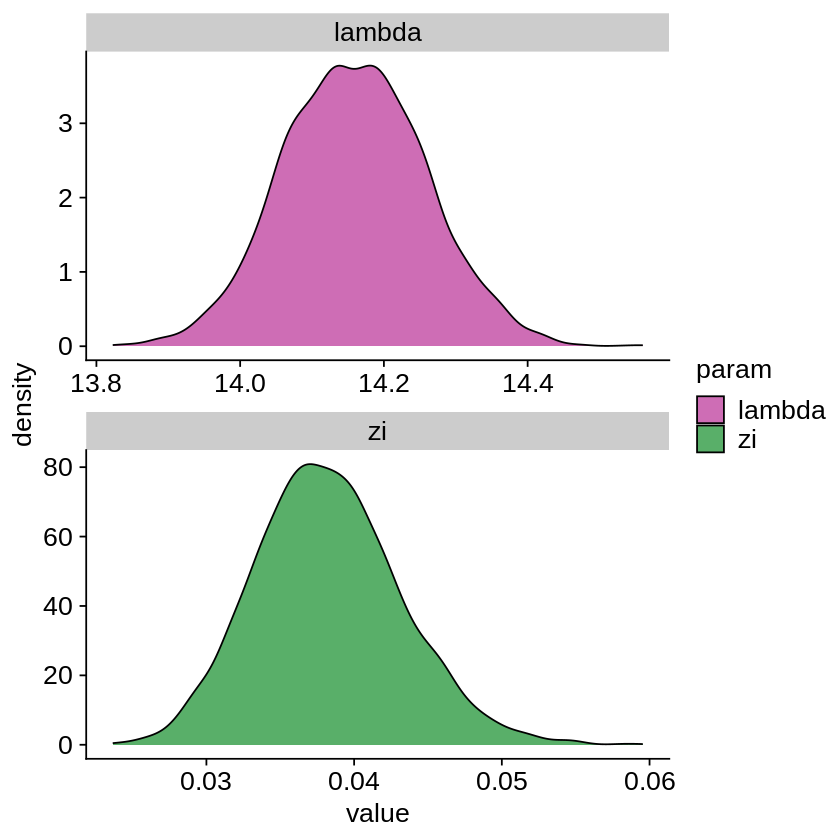

In [18]:
model |>
    spread_draws(b_Intercept, zi) |>
    mutate(lambda = exp(b_Intercept)) |>
    select(zi, lambda) |>
    pivot_longer(cols= everything(),names_to = "param") |>
    ggplot(aes(x = value, fill = param))+
    geom_density()+
    facet_wrap(~param,scales = "free",nrow = 2)

And, now, we are going how generated data with our generative model and parameters sampled from the posterior looks like: 

In [19]:
set.seed(1)
counts <- model |>
    spread_draws(b_Intercept, zi) |>
    rowwise()|>
    mutate(count = rbinom(1, 1, 1-zi) * rpois(1, exp(b_Intercept))) |>
    pull(count) |>
    sample(size = nrow(data2),replace = TRUE)

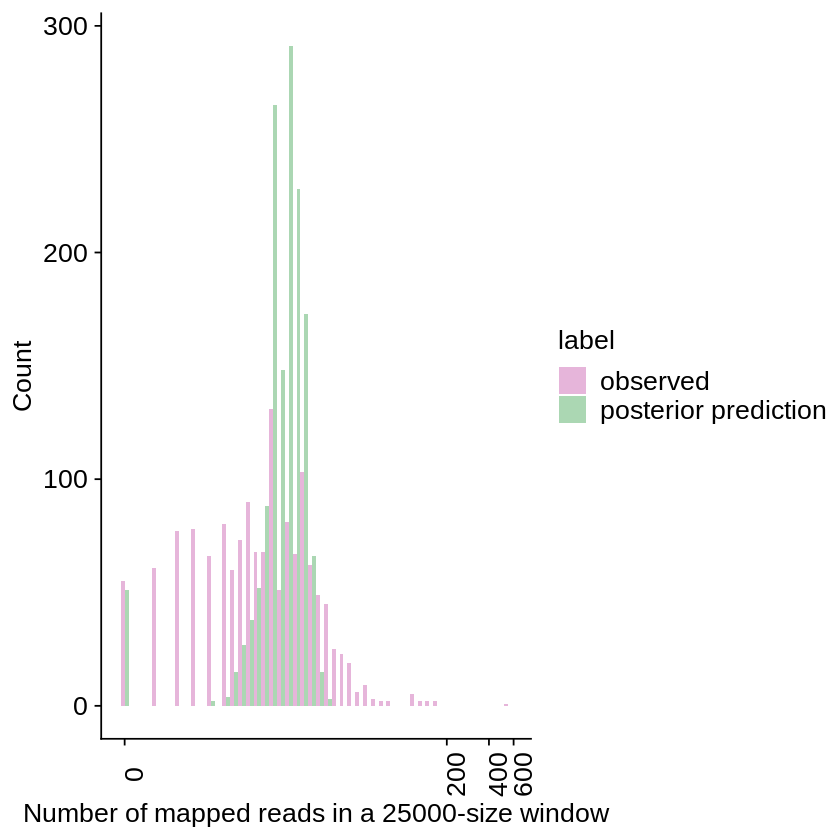

In [20]:
tibble(
    Y = c(data2$reads_all, counts),
    label = c(rep("observed", nrow(data2)), rep("posterior prediction", nrow(data2)))
) |>
    ggplot(aes(x = Y, fill = label))+
    geom_histogram(alpha = 0.5, position = "dodge", bins= 50)+
  xlab("Number of mapped reads in a 25000-size window")+
  ylab("Count")+
  scale_x_continuous(
    trans = pseudo_log_trans()
    )+ 
  theme(axis.text.x = element_text(angle = 90))

### Modelling one chromosome using a smaller window size

In [21]:
data3 <- read_tsv("../results/aligned_stats/binned_coverage.txt") |>
    filter(chrom == "CM044164.1")
set.seed(1)
model <- brm(
    data = data3, family = zero_inflated_poisson,
    reads_all ~ 1,
    prior = c(
        prior(normal(0, 10), class = Intercept),
        prior(beta(1, 1), class = zi)),
    cores = 8,file = "small_window_brm_CM044164.1.rds", seed = 11) 
model

Rows: 528906 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chrom
dbl (4): pos, gc, reads_all, reads_pp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


 Family: zero_inflated_poisson 
  Links: mu = log; zi = identity 
Formula: reads_all ~ 1 
   Data: data3 (Number of observations: 36630) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.76      0.01     0.75     0.78 1.00     2721     2452

Family Specific Parameters: 
   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
zi     0.75      0.00     0.74     0.75 1.00     2976     2827

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

First, we are going to take a look to how the posterior distribution looks:

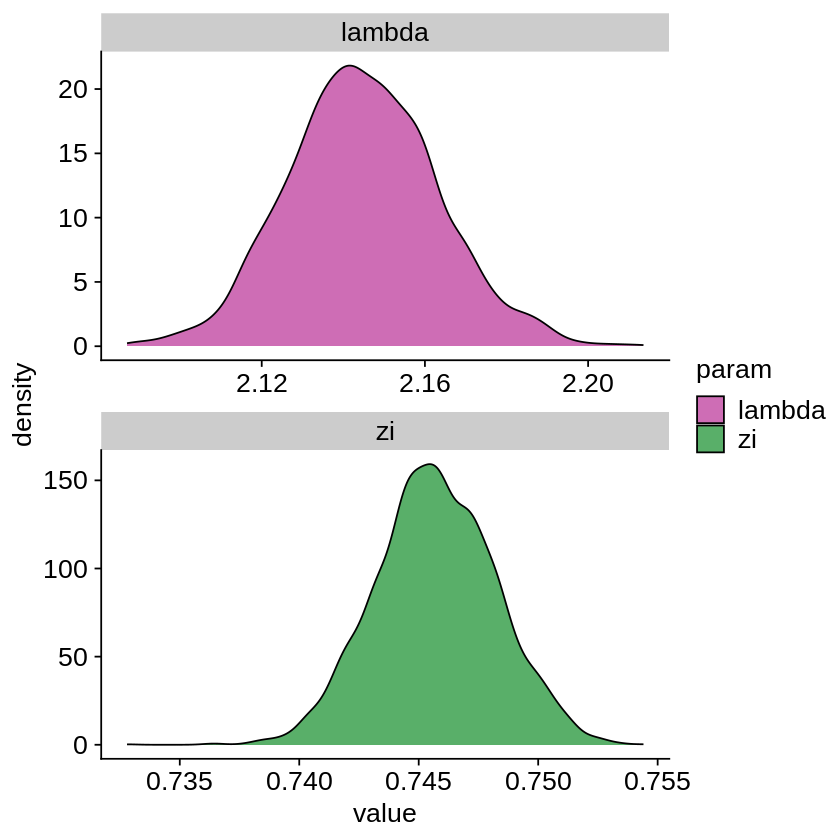

In [22]:
model |>
    spread_draws(b_Intercept, zi) |>
    mutate(lambda = exp(b_Intercept)) |>
    select(zi, lambda) |>
    pivot_longer(cols= everything(),names_to = "param") |>
    ggplot(aes(x = value, fill = param))+
    geom_density()+
    facet_wrap(~param,scales = "free",nrow = 2)

And, now, we are going how generated data with our generative model and parameters sampled from the posterior looks like: 

In [23]:
set.seed(1)
counts <- model |>
    spread_draws(b_Intercept, zi) |>
    rowwise()|>
    mutate(count = rbinom(1, 1, 1-zi) * rpois(1, exp(b_Intercept))) |>
    pull(count) |>
    sample(size = nrow(data3),replace = TRUE)

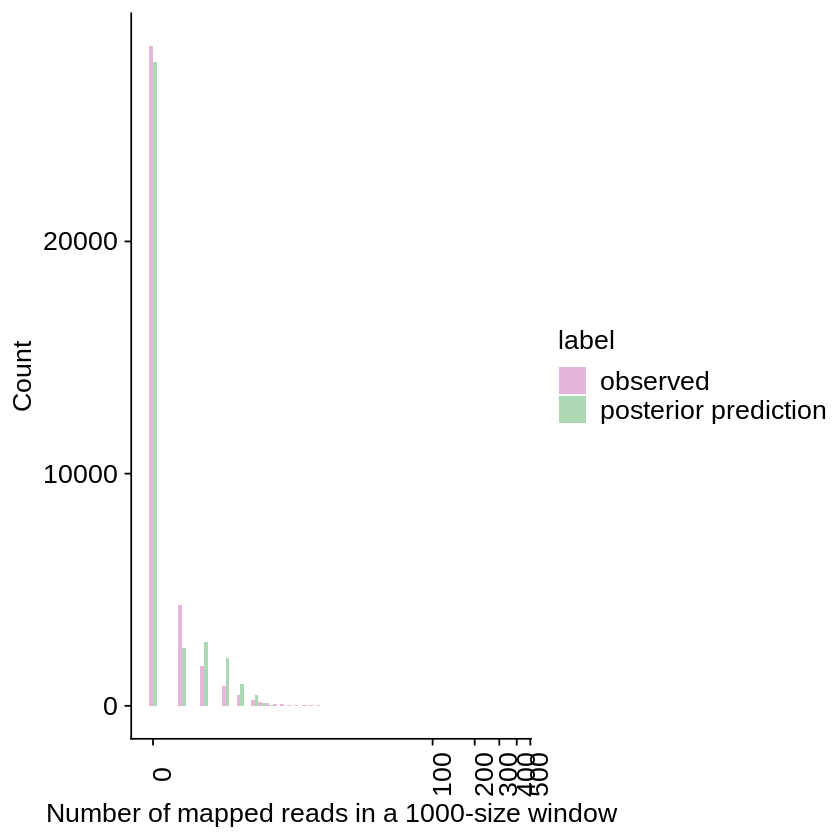

In [24]:
tibble(
    Y = c(data3$reads_all, counts),
    label = c(rep("observed", nrow(data3)), rep("posterior prediction", nrow(data3)))
) |>
    ggplot(aes(x = Y, fill = label))+
    geom_histogram(alpha = 0.5, position = "dodge", bins= 50)+
  xlab("Number of mapped reads in a 1000-size window")+
  ylab("Count")+
  scale_x_continuous(
    trans = pseudo_log_trans()
    )+ 
  theme(axis.text.x = element_text(angle = 90))

I have mixed ideas. On the one hand, a smaller window means that there is not as much variance. On the other hand, using a window size smaller than the average size of the alignment does not seem appropriate. 

## Likelihood approach (now giving the exact same results 🤣)

In [25]:
library(pscl)
summary(m1 <- zeroinfl(reads_all ~ 1 | 1, data = data3))

Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis




Call:
zeroinfl(formula = reads_all ~ 1 | 1, data = data3)

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.458  -0.458  -0.458  -0.458 296.021 

Count model coefficients (poisson with log link):
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.76307    0.00836    91.2   <2e-16 ***

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.0760     0.0134    80.3   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Number of iterations in BFGS optimization: 6 
Log-likelihood: -3.9e+04 on 2 Df

In [26]:
logit2prob <- function(logit){
  odds <- exp(logit)
  prob <- odds / (1 + odds)
  return(prob)
}

(p <- logit2prob(1.07603))
(lambda <- exp(0.763069))
counts <- generative_model(nrow(data3), p, lambda)

[1] 0.746

[1] 2.14

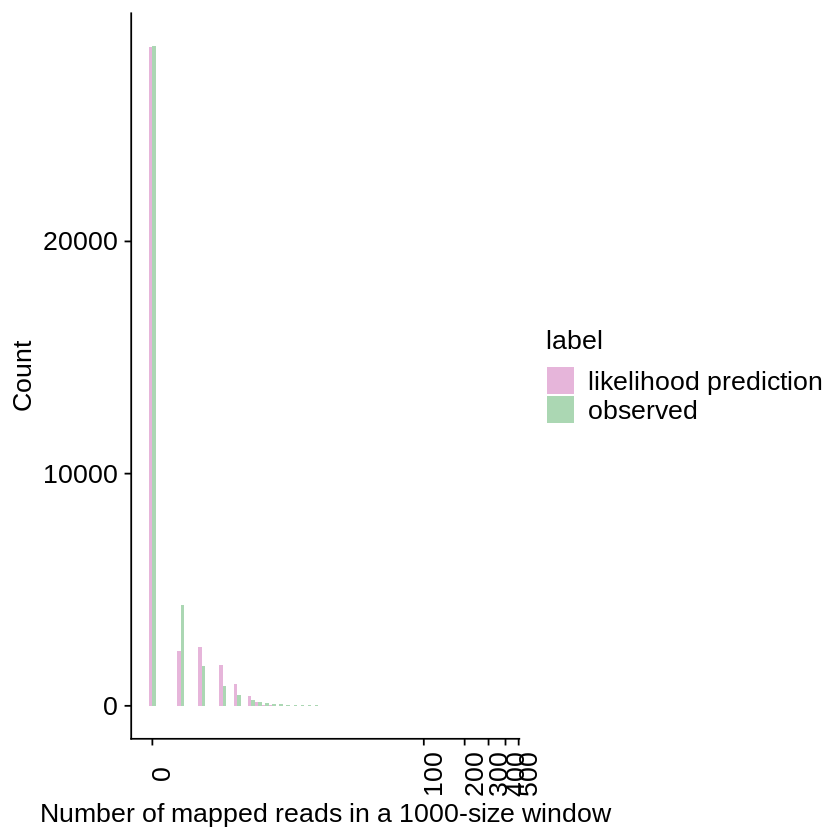

In [27]:
tibble(
    Y = c(data3$reads_all, counts),
    label = c(rep("observed", nrow(data3)), rep("likelihood prediction", nrow(data3)))
) |>
    ggplot(aes(x = Y, fill = label))+
    geom_histogram(alpha = 0.5, position = "dodge", bins= 50)+
  xlab("Number of mapped reads in a 1000-size window")+
  ylab("Count")+
  scale_x_continuous(
    trans = pseudo_log_trans()
    )+ 
  theme(axis.text.x = element_text(angle = 90))